# Deep Convolutional Generative Adversarial Network

### Setup

In [33]:
import tensorflow as tf

In [34]:
tf.__version__

'2.17.0'

In [35]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /private/var/folders/6q/h812b4x57vl9tkkrtb9c5w0r0000gn/T/pip-req-build-n7cjezdy
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/6q/h812b4x57vl9tkkrtb9c5w0r0000gn/T/pip-req-build-n7cjezdy
  Resolved https://github.com/tensorflow/docs to commit 0c634f4f3bd7ee661a92bf6f3f753931bc511192
  Preparing metadata (setup.py) ... done


In [36]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
layers = tf.keras.layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [37]:
!pip install medmnist


In [38]:
import numpy as np
from medmnist import ChestMNIST


In [39]:
# Load training data
train_dataset = ChestMNIST(split='train', download=True)
train_images = train_dataset.imgs
train_labels = train_dataset.labels

# Load test data
test_dataset = ChestMNIST(split='test', download=True)
test_images = test_dataset.imgs
test_labels = test_dataset.labels


In [40]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [41]:
# Normalize images to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

In [42]:
# Expand dimensions to include channel information if necessary
if train_images.ndim == 3:
    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

In [43]:
import numpy as np

# Path to your ChestMNIST .npz file
data_path = "/Users/darshilshah/.medmnist/chestmnist.npz"

# Load the .npz file
data = np.load(data_path)

# List the keys stored in the file
print("Keys in the .npz file:", data.files)

# For example, if the file contains training images and labels:
train_images = data['train_images']  # Adjust key names as appropriate
train_labels = data['train_labels']

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)


Keys in the .npz file: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
Train images shape: (78468, 28, 28)
Train labels shape: (78468, 14)


In [44]:
import numpy as np

# Set the fraction you want to keep (e.g., 10% of the data)
fraction = 0.1

def sample_subset(images, labels, fraction):
    """
    Randomly samples a fraction of the images and labels.
    
    Args:
        images (np.ndarray): Array of images.
        labels (np.ndarray): Array of corresponding labels.
        fraction (float): Fraction of the dataset to keep (0.0 - 1.0).
        
    Returns:
        tuple: (subset_images, subset_labels)
    """
    num_samples = int(len(images) * fraction)
    # Get a random permutation of indices
    indices = np.random.permutation(len(images))[:num_samples]
    return images[indices], labels[indices]

# Assuming you've already loaded your ChestMNIST dataset from the .npz file:
data_path = "/Users/darshilshah/.medmnist/chestmnist.npz"
data = np.load(data_path)

# Full datasets
train_images_full = data['train_images']
train_labels_full = data['train_labels']
val_images_full = data['val_images']
val_labels_full = data['val_labels']
test_images_full = data['test_images']
test_labels_full = data['test_labels']

# Sample reduced subsets from each split
train_images, train_labels = sample_subset(train_images_full, train_labels_full, fraction)
val_images, val_labels = sample_subset(val_images_full, val_labels_full, fraction)
test_images, test_labels = sample_subset(test_images_full, test_labels_full, fraction)

# Display new shapes to verify the reduction
print("Reduced Train images shape:", train_images.shape)
print("Reduced Train labels shape:", train_labels.shape)
print("Reduced Val images shape:", val_images.shape)
print("Reduced Val labels shape:", val_labels.shape)
print("Reduced Test images shape:", test_images.shape)
print("Reduced Test labels shape:", test_labels.shape)


Reduced Train images shape: (7846, 28, 28)
Reduced Train labels shape: (7846, 14)
Reduced Val images shape: (1121, 28, 28)
Reduced Val labels shape: (1121, 14)
Reduced Test images shape: (2243, 28, 28)
Reduced Test labels shape: (2243, 14)


In [45]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [46]:
BATCH_SIZE = 64
BUFFER_SIZE = 60000

In [47]:


train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [48]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [49]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

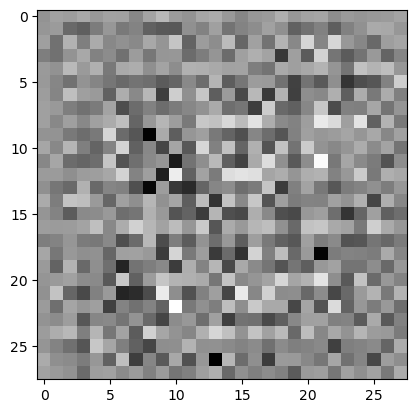

In [50]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [51]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [52]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0002986]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [53]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [54]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [55]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [56]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [58]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [59]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [60]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [61]:
import tensorflow as tf
import time
from IPython import display



# Optionally initialize checkpoints if you're using them
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint_prefix = './training_checkpoints/cp.ckpt'

@tf.function
def train_step(image_batch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Forward pass through the generator and discriminator
        generated_images = generator(noise, training=True)
        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute the loss and gradients
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients and update the models
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [62]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [63]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

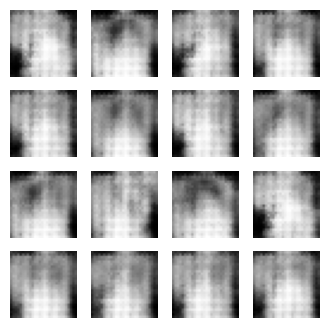

In [64]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [65]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [66]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

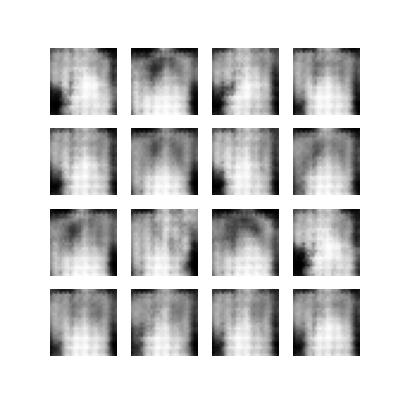

In [67]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [68]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/var/folders/6q/h812b4x57vl9tkkrtb9c5w0r0000gn/T/ipykernel_28079/1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/6q/h812b4x57vl9tkkrtb9c5w0r0000gn/T/ipykernel_28079/1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



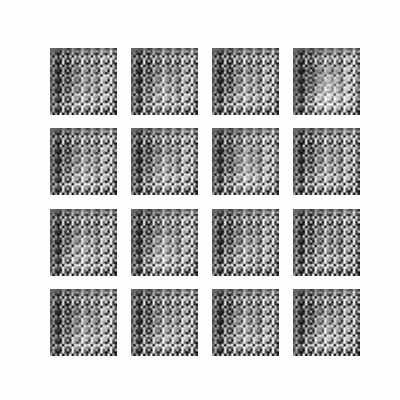

In [69]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Using device: cpu
Instructions for updating:
Use tf.identity with explicit device placement instead.


Instructions for updating:
Use tf.identity with explicit device placement instead.


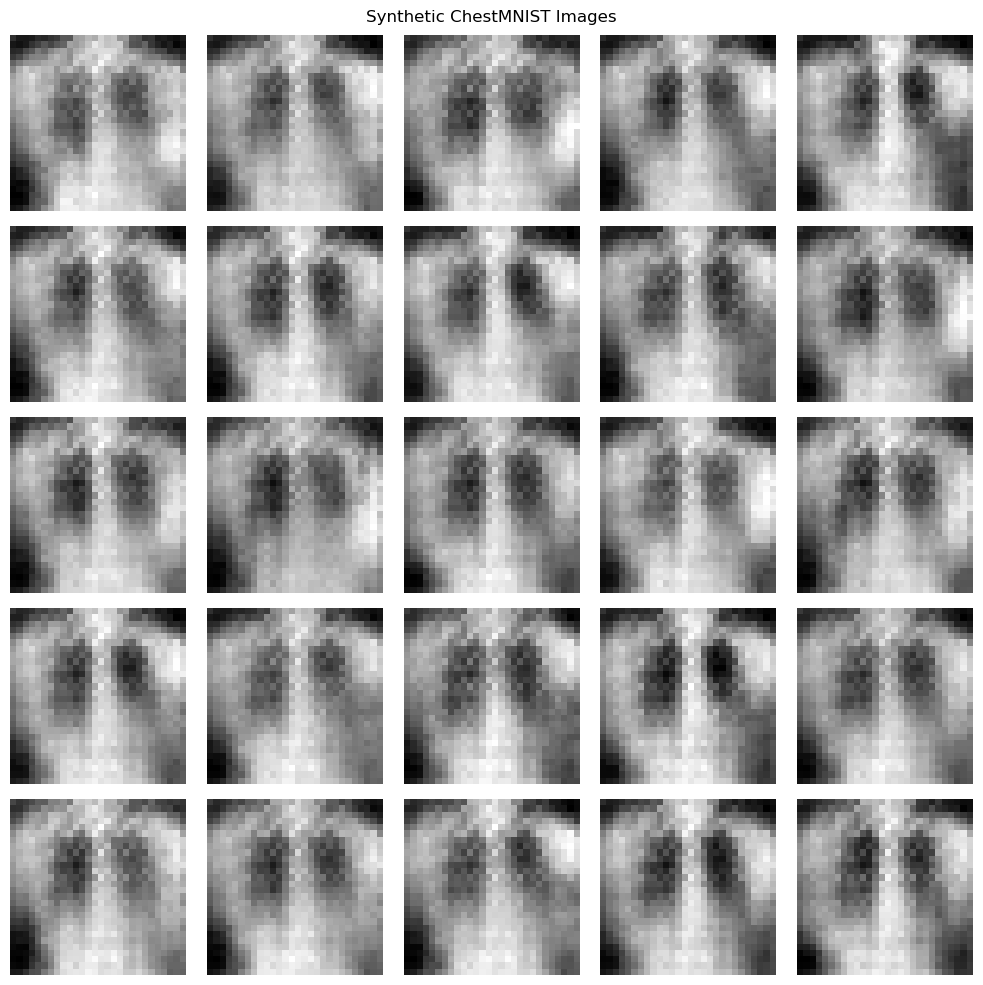

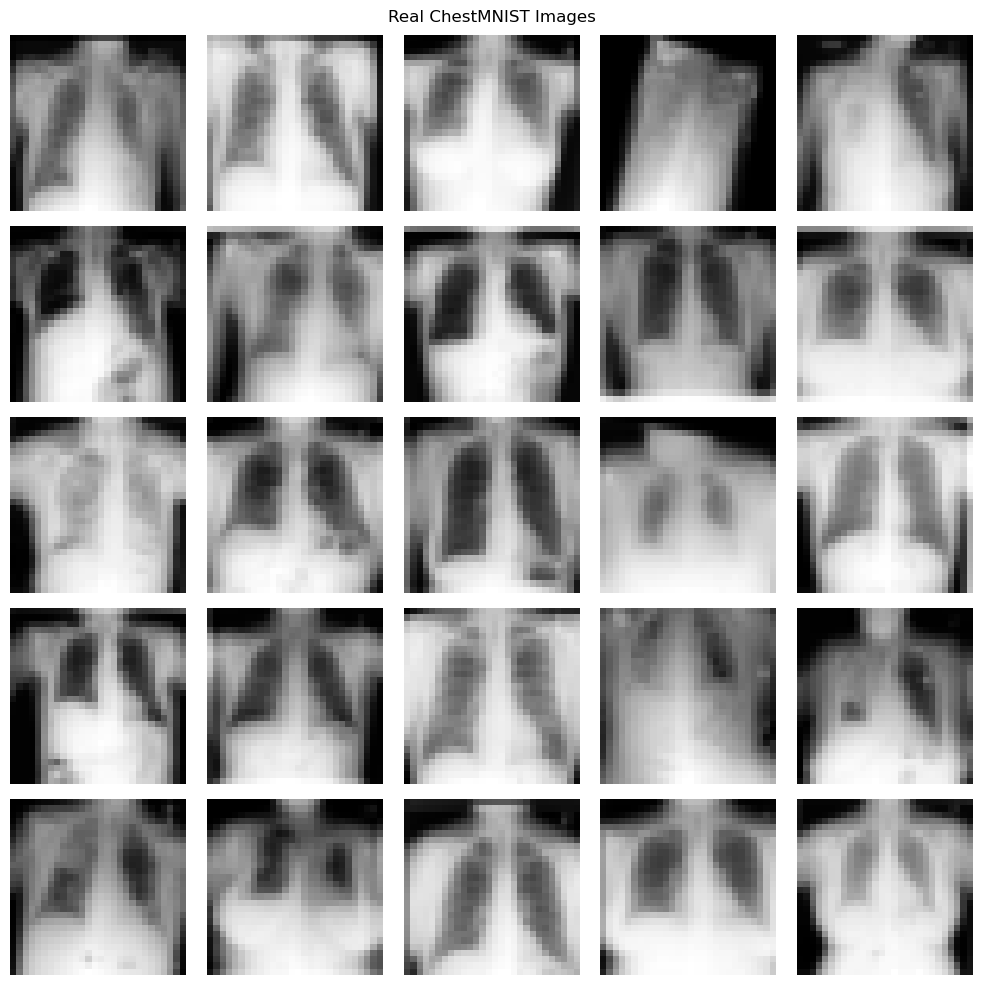

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Set up the device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------
# Helper functions for Part 2
# ---------------------------

def evaluate_generator(generator, device, noise_dim, num_samples=100):
    """
    Generate synthetic images using the trained Generator model.
    
    Args:
        generator (torch.nn.Sequential): The trained Generator (Sequential model).
        device (torch.device): Device to run the generation.
        noise_dim (int): Dimensionality of the noise vector.
        num_samples (int): Number of synthetic images to generate.
        
    Returns:
        np.ndarray: Generated synthetic images.
    """
    with torch.no_grad():  # Ensure no gradients are computed
        # Generate random noise vectors
        noise = torch.randn(num_samples, noise_dim, device=device)
        # Produce synthetic images
        fake_images = generator(noise).cpu().numpy()  # Convert to NumPy
    return fake_images


def plot_generated_images(images, grid_size=5, title="Generated Images"):
    """
    Plot a grid of images.
    
    Args:
        images (np.ndarray): Array of images to plot.
        grid_size (int): Number of images per row/column.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 10))
    total = grid_size * grid_size
    for i in range(total):
        plt.subplot(grid_size, grid_size, i + 1)
        img = np.squeeze(images[i])  # Remove extra dimensions if necessary
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()




# Generate synthetic images using your trained generator.
synthetic_images = evaluate_generator(generator, device, noise_dim, num_samples=100)

# Display a grid of synthetic images.
plot_generated_images(synthetic_images, grid_size=5, title="Synthetic ChestMNIST Images")

# For visual comparison, also display a grid of real images.
plot_generated_images(train_images, grid_size=5, title="Real ChestMNIST Images")
